In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [13]:
data = pd.read_csv('hotel_bookings.csv')
print(data.shape)
print(data.info())

(119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel         

In [14]:
# 删除company列
data_new = data.copy(deep = True)
data_new.drop("company", axis=1, inplace=True)

In [15]:
# 对agent children country的缺失值使用该属性的众数填充
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)

print(data_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           119390 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [16]:
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)

data_new["meal"].replace("Undefined", "SC", inplace=True)

# 将变量 adults + children + babies == 0 的数据删除
zero_guests = list(data_new["adults"] +
                  data_new["children"] +
                  data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)

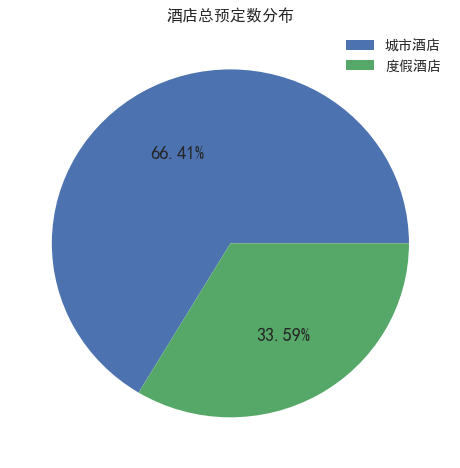

In [17]:
plt.rcParams['font.sans-serif']=['simhei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False     # 正常显示负号
# 从预定是否取消考虑
rh_iscancel_count = data_new[data_new["hotel"]=="Resort Hotel"].groupby(["is_canceled"])["is_canceled"].count()
ch_iscancel_count = data_new[data_new["hotel"]=="City Hotel"].groupby(["is_canceled"])["is_canceled"].count()

rh_cancel_data = pd.DataFrame({"hotel": "度假酒店",
                              "is_canceled": rh_iscancel_count.index,
                              "count": rh_iscancel_count.values})

ch_cancel_data = pd.DataFrame({"hotel": "城市酒店",
                              "is_canceled": ch_iscancel_count.index,
                              "count": ch_iscancel_count.values})
iscancel_data = pd.concat([rh_cancel_data, ch_cancel_data], ignore_index=True)

plt.figure(figsize=(8, 8))
w, t, autotexts = plt.pie(data_new["hotel"].value_counts(), autopct="%.2f%%",textprops={"fontsize":18})
plt.title("酒店总预定数分布", fontsize=16)
plt.legend(w, (iscancel_data.loc[iscancel_data.is_canceled==1, "hotel"].value_counts().index)[::-1], loc="upper right",
          fontsize=14)

plt.show()

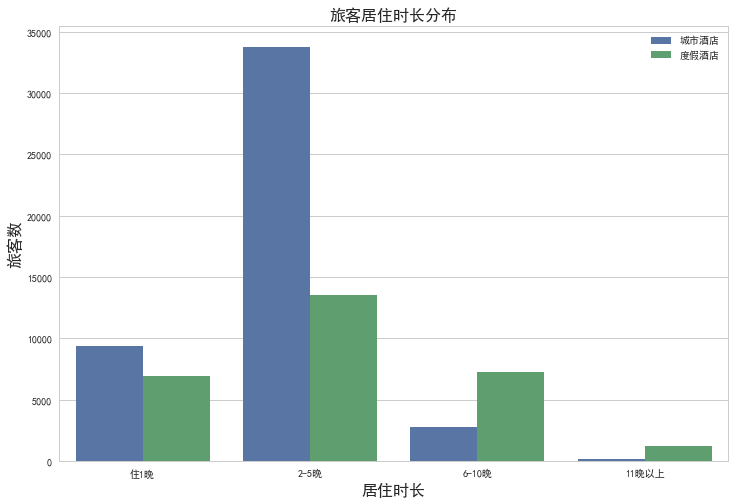

In [18]:
full_data_guests = data_new.loc[data_new["is_canceled"] == 0]

full_data_guests["total_nights"] = full_data_guests["stays_in_weekend_nights"] + full_data_guests["stays_in_week_nights"]

# 新建字段：total_nights_bin——居住时长区间
full_data_guests["total_nights_bin"] = "住1晚"
full_data_guests.loc[(full_data_guests["total_nights"]>1)&(full_data_guests["total_nights"]<=5), "total_nights_bin"] = "2-5晚"
full_data_guests.loc[(full_data_guests["total_nights"]>5)&(full_data_guests["total_nights"]<=10), "total_nights_bin"] = "6-10晚"
full_data_guests.loc[(full_data_guests["total_nights"]>10), "total_nights_bin"] = "11晚以上"

ch_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts()
rh_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts()

ch_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts().index
rh_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts().index

ch_nights_data = pd.DataFrame({"hotel": "城市酒店",
                               "nights": ch_nights_index,
                              "guests": ch_nights_count})
rh_nights_data = pd.DataFrame({"hotel": "度假酒店",
                               "nights": rh_nights_index,
                              "guests": rh_nights_count})
# 绘图数据
nights_data = pd.concat([ch_nights_data, rh_nights_data], ignore_index=True)
order = ["住1晚", "2-5晚", "6-10晚", "11晚以上"]
nights_data["nights"] = pd.Categorical(nights_data["nights"], categories=order, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x="nights", y="guests", hue="hotel", data=nights_data)
plt.title("旅客居住时长分布", fontsize=16)
plt.xlabel("居住时长", fontsize=16)
plt.ylabel("旅客数", fontsize=16)

plt.legend()
plt.show()

In [19]:
# 将分类数据进行标签化处理，方便进行后续的相关性计算
le = LabelEncoder()
data_copy=data_new.copy()
data_copy['agent']= data_copy['agent'].astype(int)
data_copy['country']= data_copy['country'].astype(str)

data_copy['hotel'] = le.fit_transform(data_copy['hotel'])
data_copy['arrival_date_month'] = le.fit_transform(data_copy['arrival_date_month'])
data_copy['meal'] = le.fit_transform(data_copy['meal'])
data_copy['country'] = le.fit_transform(data_copy['country'])
data_copy['market_segment']= le.fit_transform(data_copy['market_segment'])
data_copy['distribution_channel']=le.fit_transform(data_copy['distribution_channel'])
data_copy['is_repeated_guest'] = le.fit_transform(data_copy['is_repeated_guest'])
data_copy['reserved_room_type'] = le.fit_transform(data_copy['reserved_room_type'])
data_copy['assigned_room_type'] = le.fit_transform(data_copy['assigned_room_type'])
data_copy['deposit_type'] = le.fit_transform(data_copy['deposit_type'])
data_copy['agent'] = le.fit_transform(data_copy['agent'])
data_copy['customer_type'] = le.fit_transform(data_copy['customer_type'])
data_copy['reservation_status'] = le.fit_transform(data_copy['reservation_status'])

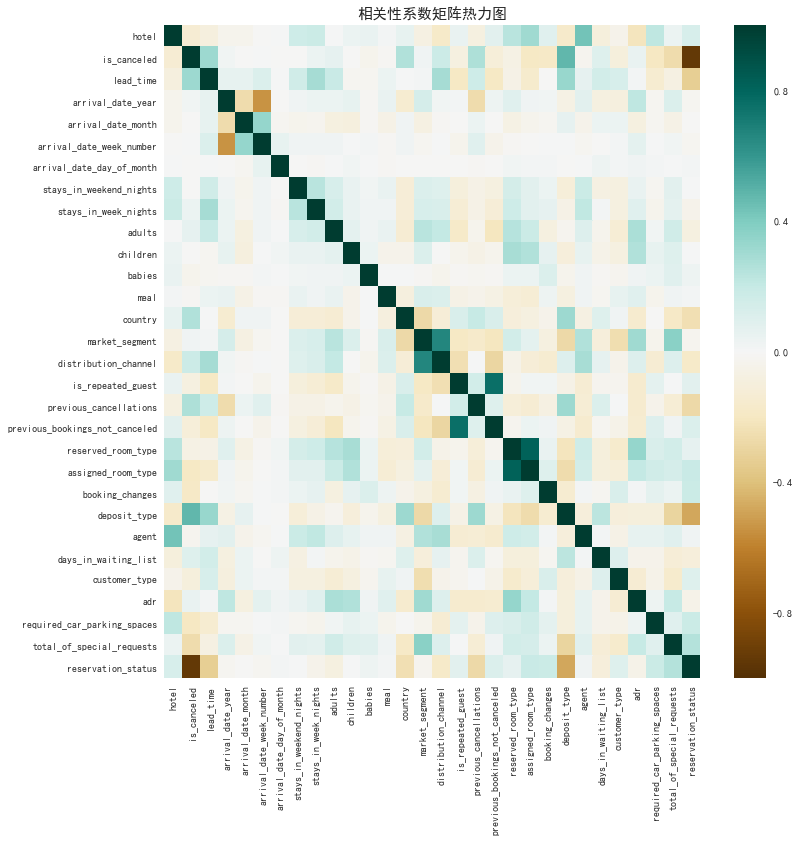

In [20]:
data_corr=data_copy.corr(method='spearman')

plt.figure(figsize=(12, 12))
sns.heatmap(data_corr,cmap='BrBG', vmin=-1, vmax=1)
plt.title('相关性系数矩阵热力图',size=15, weight='bold')
plt.show()

In [21]:
np.abs(data_corr['is_canceled']).sort_values(ascending=False)

is_canceled                       1.000000
reservation_status                0.942700
deposit_type                      0.477106
lead_time                         0.316448
previous_cancellations            0.270316
country                           0.260578
total_of_special_requests         0.258743
required_car_parking_spaces       0.197604
assigned_room_type                0.188025
booking_changes                   0.184299
distribution_channel              0.173747
hotel                             0.137082
previous_bookings_not_canceled    0.115395
customer_type                     0.099376
days_in_waiting_list              0.098417
is_repeated_guest                 0.083745
reserved_room_type                0.068031
adults                            0.065668
adr                               0.049927
stays_in_week_nights              0.041431
babies                            0.034390
market_segment                    0.026340
agent                             0.024745
arrival_dat

In [22]:
# 为了使模型更通用并防止泄漏，排除了一些列
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

In [23]:
#预处理数值特征：
#对于大多数num cols，除了日期，0是最符合逻辑的填充值
#这里没有日期遗漏。
num_transformer = SimpleImputer(strategy="constant")

# 分类特征的预处理：
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的束预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

# 定义要测试的模型：
base_models = [("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]

In [24]:
# 将数据分成“kfold”部分进行交叉验证
# 使用shuffle确保数据的随机分布：
kfolds = 4  # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

#对模型进行预处理、拟合、预测和评分：
for name, model in base_models:
    #将数据和模型的预处理打包到管道中：
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    #获取模型的交叉验证分数：
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} min: {min_score}, max: {max_score}")

LR_model cross validation accuarcy score: 0.7957 min: 0.7937, max: 0.7968
